In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, ttest_ind
import statsmodels.stats.power as smp
from tqdm.notebook import trange, tqdm

In [2]:
def correlated_covariate(metric, desired_corr):
    n = len(metric)
    mu_x = np.mean(metric)
    sigma_x = np.std(metric)
    
    epsilon = np.random.normal(0, sigma_x, n)
    
    covariate = (
        mu_x +
        desired_corr * (metric - mu_x) +
        np.sqrt(1 - desired_corr**2) * epsilon
    )
    return covariate

In [3]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha/2, loc = 0, scale = 1)
    t_beta = norm.ppf(1 - beta, loc = 0, scale = 1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
             z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu
    return get_sample_size_abs(epsilon, std, alpha, beta)

In [4]:
def cuped(df):
    theta = np.cov(df['metric'], df['covariate'])[0, 1]/df['covariate'].var()
    # df['cuped_metric'] = df['metric'] - theta * (df['covariate'] - df['covariate'].mean())
    df = df.with_columns(
        (pl.col("metric") - theta * (pl.col("covariate") - pl.col("covariate").mean()))
        .alias("cuped_metric")
    )

    return df

6280


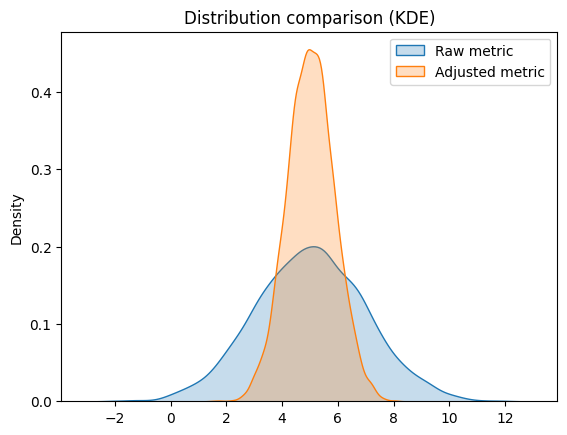

In [5]:
mu = 5
std = 2
mde = 0.1
eff = 1 + mde/mu
sample_size = get_sample_size_arb(mu, std, eff)
print(sample_size)

metric = np.random.normal(mu, std, sample_size)
data = {
    "metric": metric,
    "covariate": correlated_covariate(metric, 0.9)
}
df = pl.DataFrame(data)
df = cuped(df)

plt.figure()
sns.kdeplot(df['metric'], fill=True)
sns.kdeplot(df['cuped_metric'], fill=True)
plt.legend(["Raw metric", "Adjusted metric"])
plt.title("Distribution comparison (KDE)")
plt.show()

# Снижение требуемого размера выборки в зависимости от theta

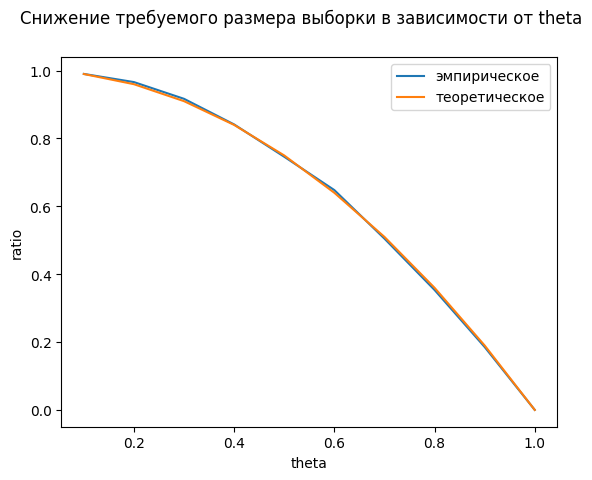

In [6]:
mu = 5
std = 1000
mde = std * 0.05
eff = 1 + mde/mu
sample_size = get_sample_size_arb(mu, std, eff)
metric = np.random.normal(mu, std, sample_size)

results = []
for i in range(10):
    theta = (i+1)/10
    data = {
        "metric": metric,
        "covariate": correlated_covariate(metric, theta)
    }
    df = pl.DataFrame(data)
    df = cuped(df)
    adjusted_std = df['cuped_metric'].std()

    adjusted_sample_size = get_sample_size_arb(mu, adjusted_std, eff)
    results.append(adjusted_sample_size/sample_size)

plot_df = pl.DataFrame({
    "theta": [(a+1)/10 for a in range(10)],
    "ratio": results,
    "theoretical_ratio": [1 - ((1+a)/10)**2 for a in range(10)]
})


plt.figure()
sns.lineplot(
    data=plot_df,
    x="theta",
    y="ratio",
    label="эмпирическое"
)

sns.lineplot(
    data=plot_df,
    x="theta",
    y="theoretical_ratio",
    label="теоретическое"
)
plt.suptitle("Снижение требуемого размера выборки в зависимости от theta")
plt.legend()

# Контроль ошибки II рода

In [7]:
def ttest(df):
    control = df.filter(df['group'] == 'control')['metric']
    treatment = df.filter(df['group'] == 'treatment')['metric']
    _, p_value = ttest_ind(control, treatment)
    return p_value

def cuped_ttest(df):
    theta = np.cov(df['metric'], df['covariate'])[0, 1]/df['covariate'].var()
    df = df.with_columns(
        (pl.col("metric") - theta * (pl.col("covariate") - pl.col("covariate").mean()))
        .alias("cuped_metric")
    )
    control = df.filter(df['group'] == 'control')['cuped_metric']
    treatment = df.filter(df['group'] == 'treatment')['cuped_metric']
    _, p_value = ttest_ind(control, treatment)
    return p_value

  0%|          | 0/5000 [00:00<?, ?it/s]

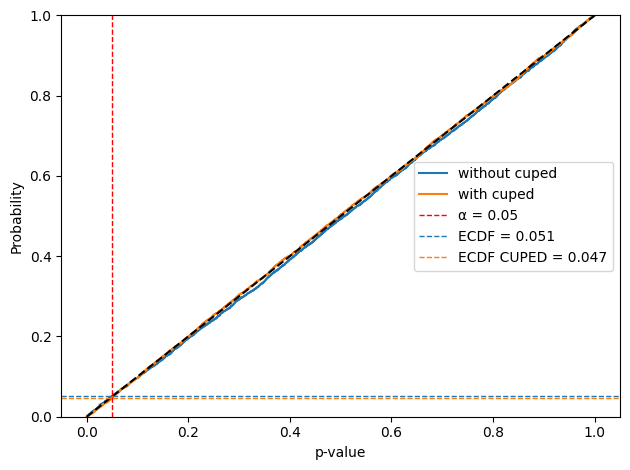

In [8]:
mu = 5
std = 2
mde = 0.1
eff = 1 + mde/mu
sample_size = get_sample_size_arb(mu, std, eff)

pvalues_without_cuped = []
pvalues_with_cuped = []
for _ in trange(5000):
    metric = np.random.normal(mu, std, sample_size*2)
    data = {
        "group": ["control"] * sample_size + ["treatment"] * sample_size,
        "metric": metric,
        "covariate": correlated_covariate(metric, 0.9)
    }
    df = pl.DataFrame(data)
    pvalues_without_cuped.append(ttest(df))
    pvalues_with_cuped.append(cuped_ttest(df))

    
plt.figure()
ax = sns.ecdfplot(x=pvalues_without_cuped, label='without cuped')
sns.ecdfplot(x=pvalues_with_cuped, label='with cuped', ax=ax)
ax.plot([0, 1], [0, 1], 'k--')
ax.set(xlabel='p-value', ylabel='Probability')
ax.axvline(0.05, color='red', linestyle='--', linewidth=1, label=f'α = {0.05}')

ecdf_value = np.mean(np.array(pvalues_without_cuped) <= 0.05)
ecdf_value_cuped = np.mean(np.array(pvalues_with_cuped) <= 0.05)

ax.axhline(ecdf_value, color=ax.lines[0].get_color(), linestyle='--', linewidth=1, 
            label=f'ECDF = {ecdf_value:.3f}')
ax.axhline(ecdf_value_cuped, color=ax.lines[1].get_color(), linestyle='--', linewidth=1, 
            label=f'ECDF CUPED = {ecdf_value_cuped:.3f}')

ax.legend()
plt.tight_layout()

# Контроль ошибки II рода

  0%|          | 0/5000 [00:00<?, ?it/s]

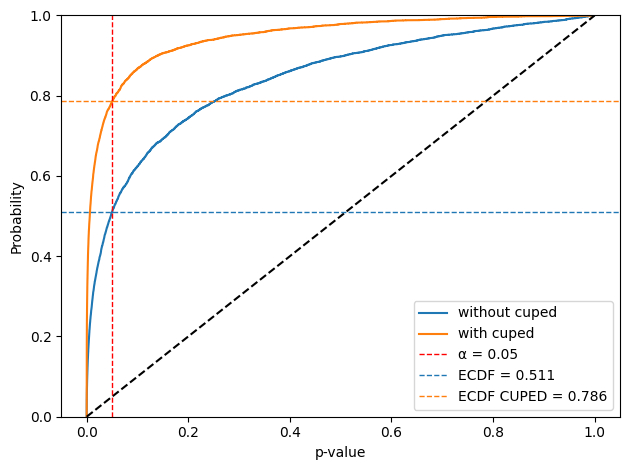

In [9]:
mu = 5
std = 2
mde = 0.1
eff = 1 + mde/mu
theta = 0.7

sample_size = get_sample_size_arb(mu, std, eff)
metric = np.random.normal(mu, std, sample_size)
data = {
    "metric": metric,
    "covariate": correlated_covariate(metric, theta)
}
df = pl.DataFrame(data)
df = cuped(df)
std_cuped = df['cuped_metric'].std()
sample_size_cuped = get_sample_size_arb(mu, std_cuped, eff)


pvalues_without_cuped = []
pvalues_with_cuped = []
for _ in trange(5000):
    metric = np.random.normal(mu, std, sample_size_cuped*2)
    control = metric[:sample_size_cuped]
    treatment = metric[sample_size_cuped:] + mde
    data = {
        "group": ["control"] * sample_size_cuped + ["treatment"] * sample_size_cuped,
        "metric": np.concatenate([control, treatment]),
        "covariate": correlated_covariate(metric, theta)
    }
    df = pl.DataFrame(data)
    pvalues_without_cuped.append(ttest(df))
    pvalues_with_cuped.append(cuped_ttest(df))

    
plt.figure()
ax = sns.ecdfplot(x=pvalues_without_cuped, label='without cuped')
sns.ecdfplot(x=pvalues_with_cuped, label='with cuped', ax=ax)
ax.plot([0, 1], [0, 1], 'k--')
ax.set(xlabel='p-value', ylabel='Probability')
ax.axvline(0.05, color='red', linestyle='--', linewidth=1, label=f'α = {0.05}')

ecdf_value = np.mean(np.array(pvalues_without_cuped) <= 0.05)
ecdf_value_cuped = np.mean(np.array(pvalues_with_cuped) <= 0.05)

ax.axhline(ecdf_value, color=ax.lines[0].get_color(), linestyle='--', linewidth=1, 
            label=f'ECDF = {ecdf_value:.3f}')
ax.axhline(ecdf_value_cuped, color=ax.lines[1].get_color(), linestyle='--', linewidth=1, 
            label=f'ECDF CUPED = {ecdf_value_cuped:.3f}')

ax.legend()
plt.tight_layout()